In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import locale

locale.setlocale(locale.LC_TIME,'fr_FR.utf8')
label_fontsize = 18


def build_data():
    
    my_df = pd.read_excel("23-24.ods", sheet_name="Journal",header=4, index_col=3,
                 parse_dates=True)
    
    # isolate km column, and remove NaN
    type_df = my_df["type"]
    km_df = my_df["km"]
    km_df.dropna(inplace=True)
    
    # reindex day by day
    new_idx = pd.date_range(start=km_df.index[0], end=km_df.index[-1], freq='D')
    km_reindexed=km_df.reindex(new_idx)
    type_reindexed=type_df.reindex(new_idx)
    
    
    
    
    
    # isolate km column, and remove NaN
    moy_df = my_df["moy"]
    moy_df.dropna(inplace=True)
    
    # reindex day by day
    new_idx = pd.date_range(start=moy_df.index[0], end=moy_df.index[-1], freq='D')
    moy_reindexed=moy_df.reindex(new_idx)

    return km_reindexed, moy_reindexed, type_reindexed


In [2]:
def show_resume(km_df, moy_df, type_df):
    import matplotlib.dates as mdates
    import locale
    locale.setlocale(locale.LC_TIME,'fr_FR.utf8')
    label_fontsize = 18
    bar_color = "black"
    moy_color = "red"
    block_types = {"foncier": "#fff5ce", "conso": "#ffd428", "recup": "#b4c7dc", "hiit": "#f10d0c", "spec": "#afd095"}

    monday_idx = pd.date_range(start=km_df.index[0], end=km_df.index[-1], freq=pd.offsets.Week(weekday=0))
    
    # print(moy_df)
    fig, ax1 = plt.subplots(1, figsize=(20,8))
    ax1.set_title("Distance et Vitesse / jour", y=1.0, pad=16)
    ax1.set_ylim([0, 130])
    
    ax1.tick_params(axis='x', labelsize=label_fontsize-5, rotation=30)
    # date_format = '%a %d %b'
    # date_format = '%d-%m-%y'
    date_format = '%d %b'
    ax1.xaxis.set_major_formatter(mdates.DateFormatter(date_format))
    ax1.set_xticks(monday_idx)
    ax1.set_xticklabels (ax1.get_xticklabels(), ha="right")
    
    ax1.set_xlabel("Semaines", fontsize=label_fontsize, labelpad=5.0, loc="left")

    # Different bar color depending on block type
    for type, type_color in block_types.items():
        mask_type = type_df == type
        km_index = km_df.index[mask_type]
        km_values = km_df[mask_type]
        bar_container = ax1.bar(km_index,km_values , color=type_color, width=0.8, edgecolor="black")
        ax1.bar_label(bar_container, label_type="edge", padding=10, zorder=8, color="black", fontsize=15)
            #, bbox=dict(facecolor='white', edgecolor='white'))


    ax1.set_ylabel("Distance (km)", color=bar_color, fontsize=label_fontsize, loc="bottom")
    ax1.tick_params(axis='y', labelcolor=bar_color, labelsize=label_fontsize-5)
    ax1.title.set_size(25)
    
    for monday in monday_idx:
        plt.axvline(monday,color='black', lw=0.5, alpha=0.5, linestyle='-')
        
    # for _hl in [20, 50]:
    #     ax1.axhline( _hl, color = bar_color, lw=0.5,  alpha=1, linestyle = '--') 
    
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.set_ylim([5, 27])
    color = 'tab:red'
    for _hl in [20, 25]:
        ax2.text(moy_df.index[0], _hl+0.2, f"{_hl} km/h", color=color, fontsize=12, horizontalalignment="right")
        ax2.axhline( _hl, color = color, lw=0.8,  alpha=1, linestyle = '--') 
    
    ax2.set_ylabel('vitesse moy. (km/h)', color=color, fontsize=label_fontsize, loc="top")  # we already handled the x-label with ax1
    ax2.plot(moy_df.index, moy_df.interpolate(method="spline", order=5), color="red", lw=2, zorder=-4)
    # ax2.plot(moy_df.index, moy_df, color="red", lw=2, zorder=-4)
    ax2.scatter(moy_df.index, moy_df, marker="*", zorder=3, color="lightgreen", edgecolor="black", lw=0.5, s=120)
    ax2.tick_params(axis='y', labelcolor=color, labelsize=label_fontsize-5)
    
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

In [3]:

def show_max_min_sum(km_df):
    
    
    # Reindex by week num
    km_w = km_df.copy()
    km_w.index = pd.to_datetime(km_w.index, format = '%Y-%m-%d').strftime('%W')
    var = km_w.groupby(by=km_w.index).sum()
    
    
    
    km_w = km_df.to_frame()
    km_w["w_num"] = km_w.index.strftime("%W")
    km_w_sum = km_w.groupby(by=km_w["w_num"], sort=False).agg("sum")
    km_w_mean = km_w.groupby(by=km_w["w_num"], sort=False).agg("mean")
    km_w_max = km_w.groupby(by=km_w["w_num"], sort=False).agg("max")
    
    figures_meta =[
        {"title": "Somme / semaine (km)",
         "data": km_w_sum.km,
         "xlabel": "num semaine",
         "hlines": [20, 60, 120],
         "bl_color": "black",
         "color": "orange"},
        {"title": "Moyenne / semaine (km)",
         "data": km_w_mean.km,
         "xlabel": "num semaine",
         "hlines": [20, 40, 50],
         "bl_color": "white",
         "color": "green"},
        {"title": "Sortie maximale / semaine (km)",
         "xlabel": "num semaine",
         "hlines": [20, 50, 60],
         "bl_color": "blue",
         "data": km_w_max.km,
         "color": "red"},
    ]
    
    
    fig, ax = plt.subplots(len(figures_meta),  figsize=(20,15), sharey=False)
    fig.tight_layout(pad=10.0)
    for i, _meta in enumerate(figures_meta):
        # from matplotlib import dates as mdates
        # ax2=ax[i].twiny()
        # ax2.xaxis.set_major_locator(mdates.MonthLocator())
        # ax2.xaxis.set_major_locator(mdates.MonthLocator())kjj
        # ax2.set_ylabel('Month', color="blue", fontsize=label_fontsize)  # we already handled the x-label with ax1
        # ax2.plot(new_idx)
        # ax2.scatter(moy_reindexed.index, moy_reindexed, zorder=3, color="green", edgecolor="black", lw=0.5, s=120)
        # ax2.tick_params(axis='y', labelcolor=color, labelsize=label_fontsize-5)
    
        ax[i].tick_params(axis='y', labelsize=label_fontsize-5)
        ax[i].tick_params(axis='x', labelsize=label_fontsize-5)
        ax[i].set_ylabel("Distance (km)", fontsize=label_fontsize)
        ax[i].set_xlabel(_meta["xlabel"], fontsize=label_fontsize, loc="left")
        ax[i].set_title(_meta["title"])#,  y=1.1)#, pad=-16)o
        ax[i].title.set_size(25)
        for _hl in _meta["hlines"]:
            ax[i].axhline( _hl, color = 'black', lw=1,  alpha=0.5, linestyle = '--')
        bar_container = ax[i].bar(_meta["data"].index, _meta["data"], color=_meta["color"], width=0.5, zorder=2, edgecolor="black")
        ax[i].bar_label(bar_container, label_type="center", color="black", fmt='%.f', fontsize=15,
                       bbox=dict(facecolor='white', edgecolor="black") )
    
        
        # addlabels(_meta["data"].index, _meta["data"])
    # ax[1].bar(km_w_sum.index, km_w_sum.km, color="orange", suptitle="SUM")
        
    # ax[2].bar(km_w_sum.index, km_w_mean.km, color="green")
    # ax[3].bar(km_w_sum.index, km_w_max.km, color="red")

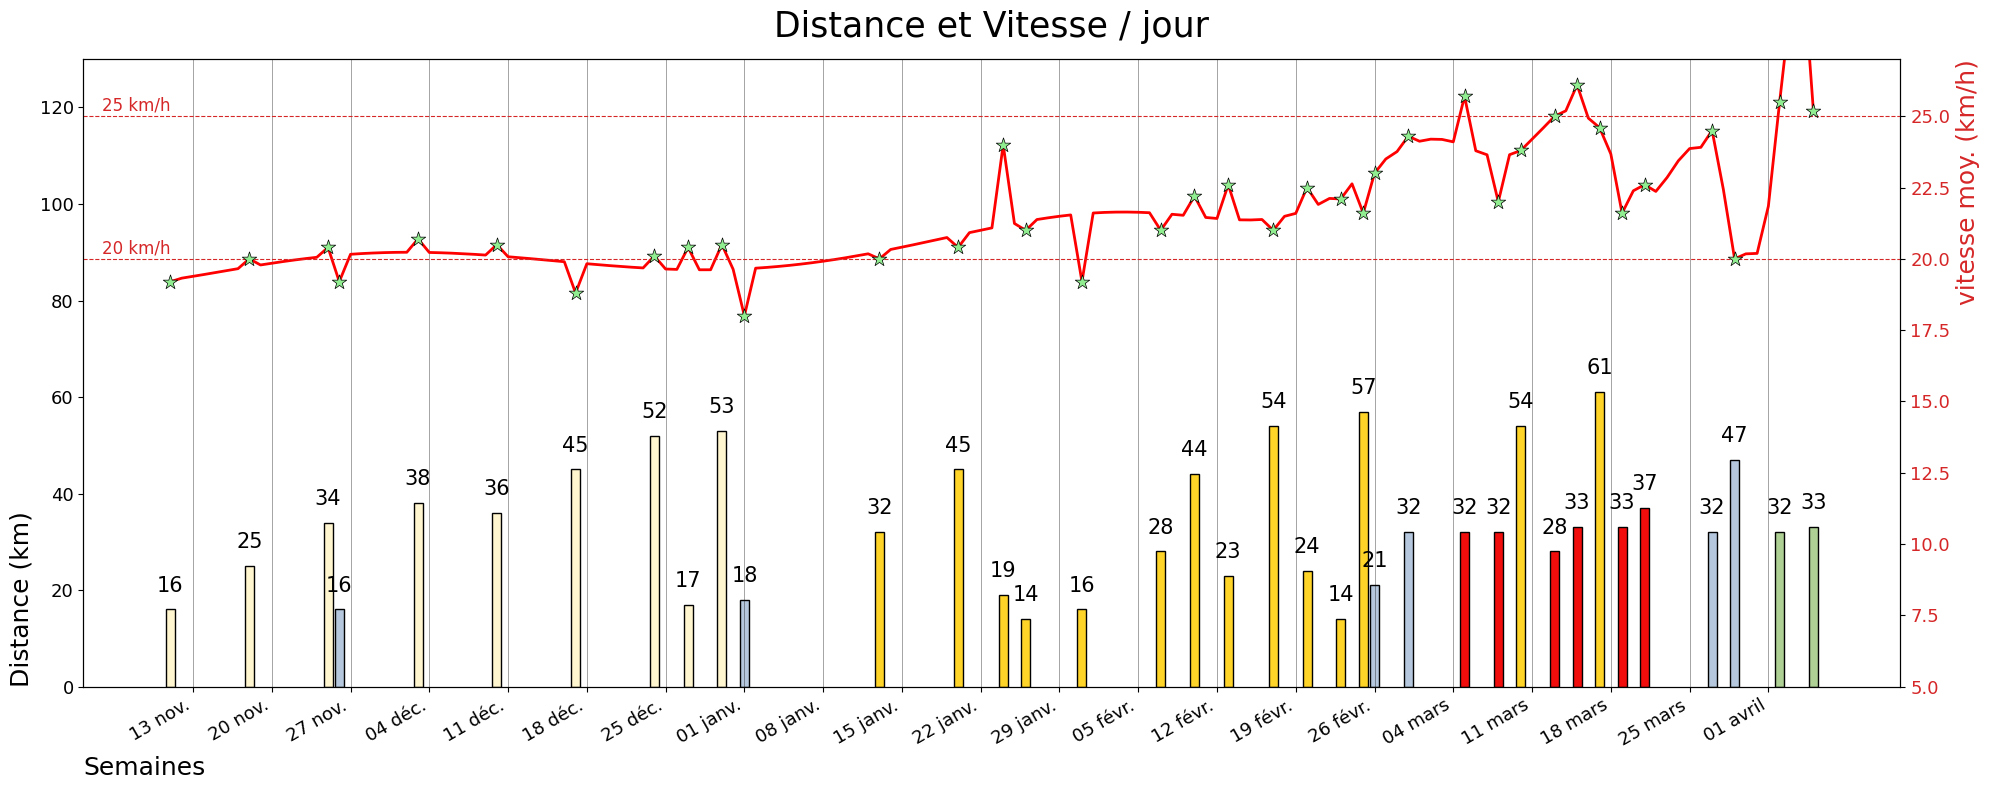

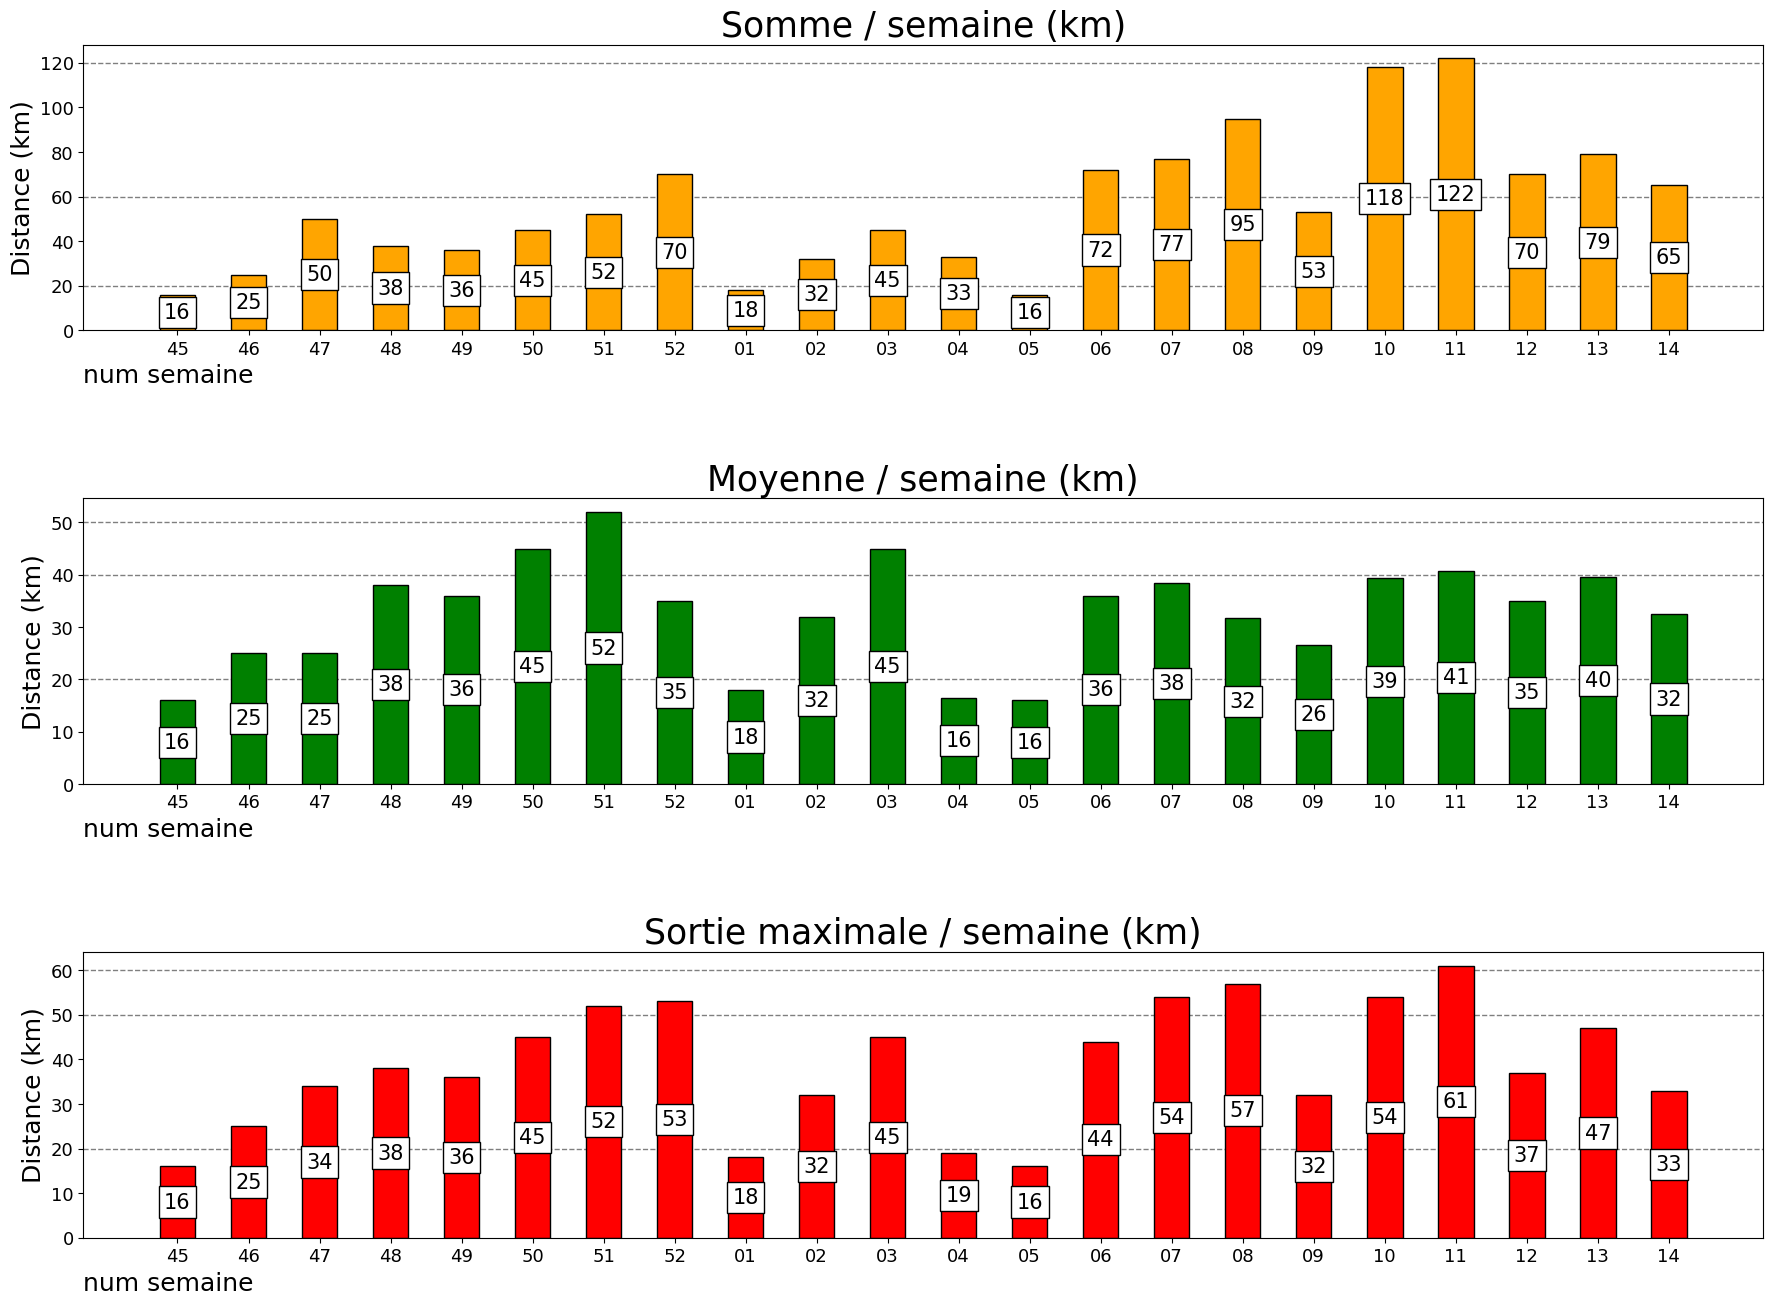

In [4]:

km_df, moy_df, type_df = build_data()

show_resume(km_df, moy_df, type_df)
show_max_min_sum(km_df)
